# Custom Neural Network

This is an evaluation of the custom fully dense neural network model I made from scratch in this project.

We will be testing how my model performs on two popular datasets:

- California Housing DataSet (https://www.kaggle.com/datasets/camnugent/california-housing-prices)
- MNIST Digit Recognization DataSet (https://www.kaggle.com/competitions/digit-recognizer/data)

My custom model was developed using the NumPy library and my own mathematical knowledge.

## California Housing Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Data Preparation

In [2]:
housing_data = pd.read_csv('Datasets\CaliforniaHousing.csv')
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


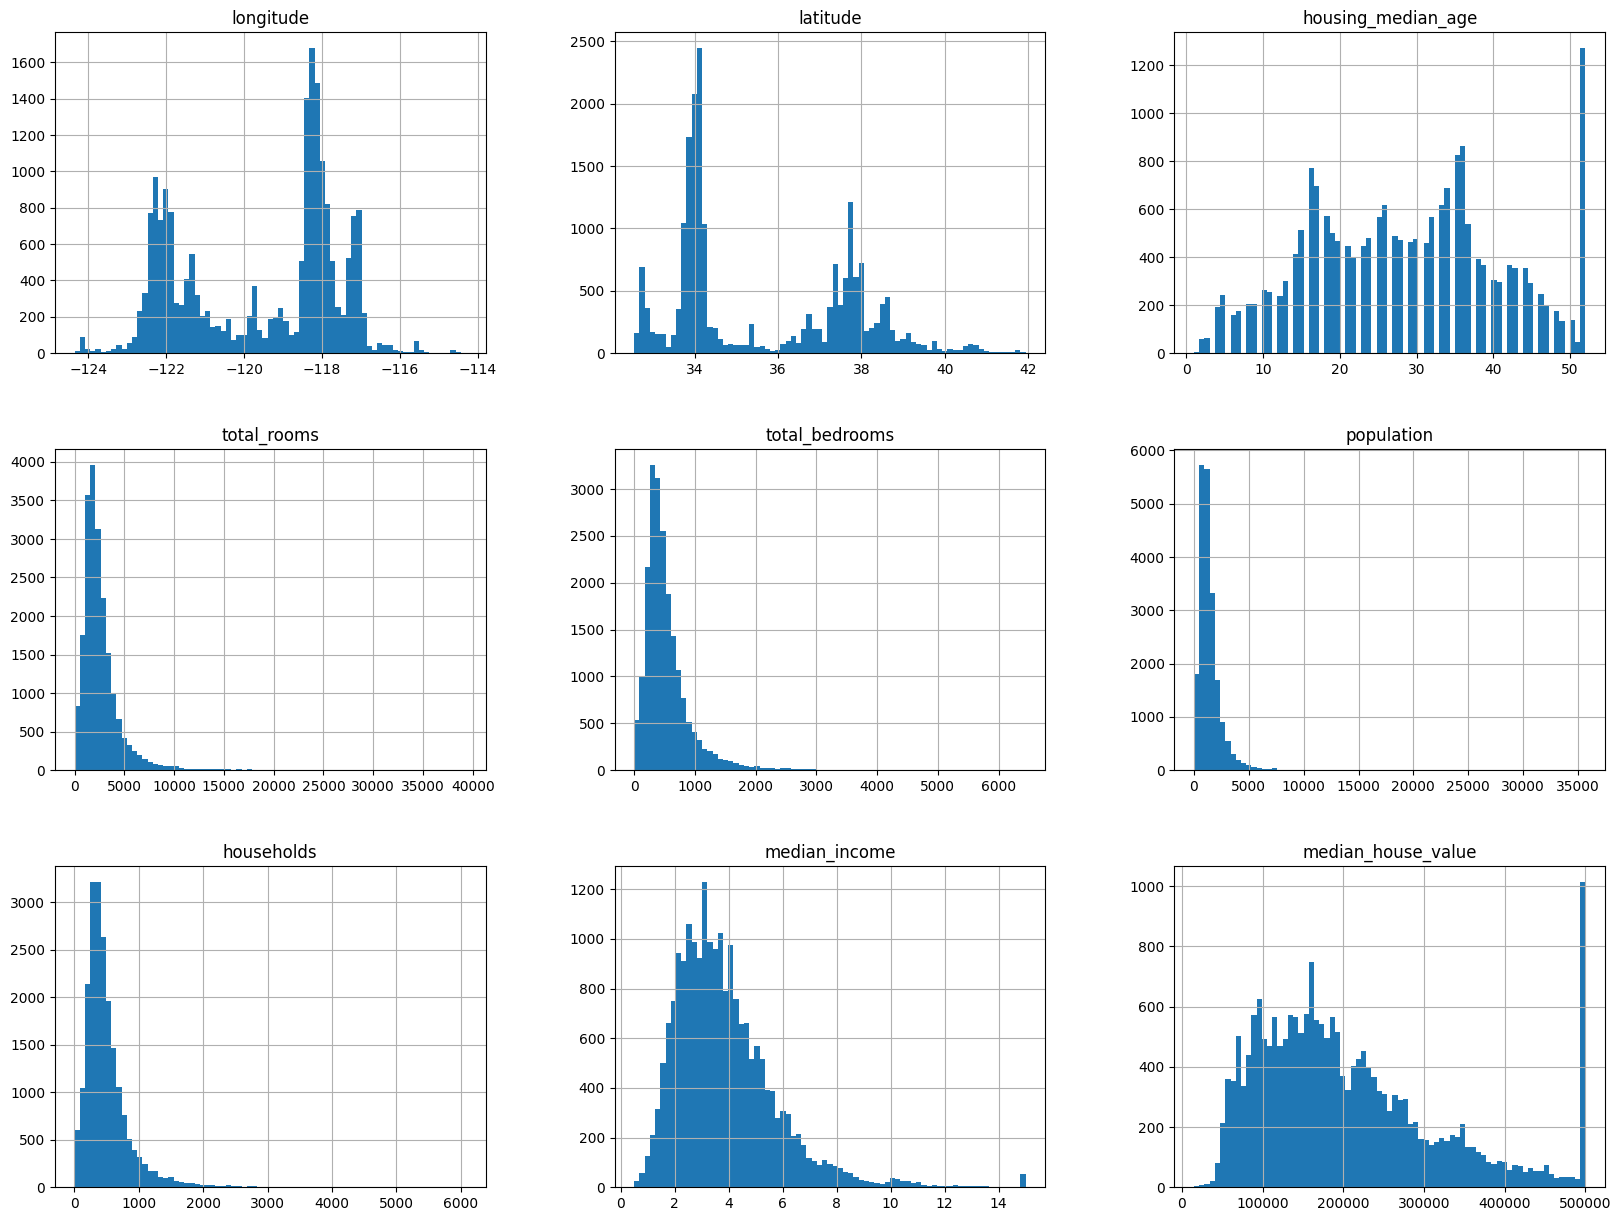

In [3]:
housing_data.hist(bins=75, figsize=(20,15))
plt.show()

### Cleaning the DataSet

First, we scramble the dataset so there will be no permuation bias.

In [4]:
housing_data = housing_data.sample(frac=1, random_state=12)
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
6906,-118.13,34.04,42.0,2205.0,451.0,1392.0,423.0,4.3646,211400.0,<1H OCEAN
767,-122.09,37.65,27.0,2630.0,722.0,1414.0,634.0,2.8203,195200.0,NEAR BAY
10555,-117.71,33.63,16.0,2497.0,500.0,1357.0,456.0,4.5909,241800.0,<1H OCEAN
17456,-120.43,34.69,33.0,2054.0,373.0,1067.0,358.0,3.6023,128300.0,NEAR OCEAN
20617,-121.53,39.06,20.0,561.0,109.0,308.0,114.0,3.3021,70800.0,INLAND


For this project, we will drop the data points with Nan values.

In [5]:
housing_data = housing_data.dropna()

Next, we will convert the text and categorical values into quantitative ones.

In [6]:
housing_data[["ocean_proximity"]].value_counts()

ocean_proximity
<1H OCEAN          9034
INLAND             6496
NEAR OCEAN         2628
NEAR BAY           2270
ISLAND                5
Name: count, dtype: int64

In [7]:
ocean_proximity_mapping = {'<1H OCEAN': 0, 'INLAND': 1, 'NEAR OCEAN': 2, 'NEAR BAY': 3, 'ISLAND': 4}
housing_data['ocean_proximity'] = housing_data['ocean_proximity'].map(ocean_proximity_mapping)
housing_data['ocean_proximity'].head()

6906     0
767      3
10555    0
17456    2
20617    1
Name: ocean_proximity, dtype: int64

### Creating Training and Test Sets

Now that we have cleaned our data, we can create the test and training sets:

(split_train_test function was borrowed from the O'Reily ML Textbook by Geron Aurelien)

In [8]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

We will use a training-test set ratio of 30:70.

In [9]:
train_set, test_set = split_train_test(housing_data, 0.3)
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
3005,-119.07,35.27,25.0,3081.0,635.0,1830.0,591.0,2.5804,97900.0,1
1062,-121.86,39.75,18.0,1651.0,309.0,856.0,293.0,3.5046,118300.0,1
5201,-118.28,33.94,9.0,456.0,130.0,438.0,114.0,0.8952,81300.0,0
13680,-117.24,34.06,9.0,3603.0,786.0,1782.0,718.0,3.2604,93300.0,1
2835,-118.99,35.40,48.0,1908.0,331.0,789.0,321.0,3.5714,84600.0,1


### Feature Scaling

In order for a neural network to perform the best, we must scale the training data down to the same scale. We will use the Sci-kit Learn Z-score normalization scaler for this.

In [24]:
from sklearn.preprocessing import StandardScaler

z_score_scaler = StandardScaler()

fitted_train_set = z_score_scaler.fit_transform(train_set)
train_X = pd.DataFrame(fitted_train_set, columns=train_set.columns).drop("median_house_value", axis=1).values
train_y = train_set["median_house_value"].values

scaled_test_set = z_score_scaler.transform(test_set)
test_X = pd.DataFrame(scaled_test_set, columns=test_set.columns).drop("median_house_value", axis=1).values
test_y = test_set["median_house_value"].values

# scale y
y_scaler = StandardScaler()
train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

train_y[:3]

array([[-0.94281531],
       [-0.76579078],
       [-1.08686468]])

Combining the shuffling and scaling into a single function:

In [31]:
def shuffle_scale(data, ratio, ):
    train_set, test_set = split_train_test(data, ratio)
    z_score_scaler = StandardScaler()

    fitted_train_set = z_score_scaler.fit_transform(train_set)
    train_X = pd.DataFrame(fitted_train_set, columns=train_set.columns).drop("median_house_value", axis=1).values
    train_y = train_set["median_house_value"].values

    scaled_test_set = z_score_scaler.transform(test_set)
    test_X = pd.DataFrame(scaled_test_set, columns=test_set.columns).drop("median_house_value", axis=1).values
    test_y = test_set["median_house_value"].values
    
    y_scaler = StandardScaler()
    train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
    test_y = y_scaler.transform(test_y.reshape(-1, 1))
    
    return train_X, train_y, test_X, test_y

Now that we have our training and test sets, we can being training our model.

### Training Model

For our model, we will use a 4 layer deep fully connected neural network with a ReLu activation function for each hidden layer.

Creating a model using my custom package is similar to Tensorflow's method.

In [37]:
from Model import *
import tensorflow as tf

my_model = Model(Layers=[
    Dense_Layer(input_shape=9,output_shape=30, activation_func="lrelu"),
    Dense_Layer(input_shape=30,output_shape=6, activation_func="lrelu"),
    Output_Layer(input_shape=6,output_shape=1)
])
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, input_shape=(9,), activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
    tf.keras.layers.Dense(6, activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
    tf.keras.layers.Dense(1)  # Output layer, no activation for regression
])

# Compile the model with SGD optimizer
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              loss='mean_absolute_error')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 30)                300       
                                                                 
 dense_16 (Dense)            (None, 6)                 186       
                                                                 
 dense_17 (Dense)            (None, 1)                 7         
                                                                 
Total params: 493
Trainable params: 493
Non-trainable params: 0
_________________________________________________________________


In [50]:
import numpy as np
import matplotlib as plt
from Dense_Layer import *
from Output_Layer import *
from Neuron import *

class oldModel:
    def __init__(self, Layers):
        self.Layers = Layers

    def get_Layers(self):
        return self.Layers

    def set_Layer(self, new_layer, layer_index):
        self.Layers[layer_index] = new_layer

    def forward_pass(self, X):
        output = X
        for layer in self.get_Layers():
            output = layer.forward_pass(output)
        return output

    def layer_output(self, X, layer_num):
        output = X
        for layer in self.get_Layers()[:layer_num]:
            output = layer.forward_pass(output)
        return output

    def dactivation(self, neuron, input):
        activation = neuron.get_activation()
        if activation=='sigmoid':
            return dsigmoid(neuron.raw_pass(input))
        elif activation=='relu':
            return drelu(neuron.raw_pass(input))
        elif activation=='lrelu':
            return dlrelu(neuron.raw_pass(input))
        else:
            return 1

    def summary(self):
        for l in self.get_Layers():
            layer_type = str(type(l))
            if 'Dense' in layer_type:
                print('Dense Layer  |',len(l.get_neurons()),'neurons |',len(l.get_neurons()[0].get_weights())-1,'weights | 1 bias')
            elif 'Output' in layer_type:
                print('Output Layer |',len(l.get_neurons()),'outputs |',len(l.get_neurons()[0].get_weights())-1,'weights | 1 bias')
        print('Input Shape:',len(self.get_Layers()[0].get_neurons()[0].get_weights())-1)
        print('Output Shape:',len(self.get_Layers()[-1].get_neurons()))

    def fit(self, X, y, learning_rate):
        error = []
        for x in range(len(X)):
            # 2d array of gradients for each layer
            layer_change_weights = []
            # derivatives of the last layer
            output_layer = self.get_Layers()[-1:][0]
            output_neurons = output_layer.get_neurons()
            prev_layer = self.get_Layers()[len(self.get_Layers())-2]
            for n in output_neurons:
                weights = n.get_weights()[:-1]
                prev_output = self.layer_output(X[x], len(self.get_Layers())-1)
                adj_weights = [weights[i]-(learning_rate*(self.forward_pass(X[x])-y[x])*output_layer.dactivation(n,X[x])*prev_output[i])[0] for i in range(len(weights))]
                adj_weights.append(n.get_weights()[-1:][0]-(learning_rate*(self.forward_pass(X[x])-y[x])*output_layer.dactivation(n,X[x]))[0])
                n.change_weights(adj_weights)
                layer_change_weights.append(adj_weights)
            output_layer.set_neurons(output_neurons)
            self.set_Layer(output_layer, len(self.get_Layers())-1)
            layers = self.get_Layers()
            for k in range(len(layers)-2):
                layer = layers[len(layers)-2-k]
                new_layer_change_weights = []
                neurons = layers[len(layers)-2-k].get_neurons()
                prev_neurons = layers[len(layers)-1-k].get_neurons()
                prev_output = self.layer_output(X[k], len(layers)-2-k)
                for j in range(len(neurons)):
                    weights = neurons[j].get_weights()[:-1]
                    d = 0
                    for l in range(len(prev_neurons)):
                        d += prev_neurons[l].get_weights()[:-1][j]*layer_change_weights[l][j]
                    d *= layers[k].dactivation(neurons[j], prev_output)
                    adj_weights = [weights[i] - (learning_rate*d*prev_output[i]) for i in range(len(weights))]
                    adj_weights.append(weights[-1:][0]-(learning_rate*d))
                    neurons[j].change_weights(adj_weights)
                    new_layer_change_weights.append(adj_weights)
                layers[len(layers)-2-k].set_neurons(neurons)
                self.set_Layer(layers[len(layers)-2-k], len(layers)-2-k)
                layer_change_weights = new_layer_change_weights
            input_layer = layers[0]
            neurons = input_layer.get_neurons()
            prev_neurons = layers[1].get_neurons()
            for j in range(len(neurons)):
                weights = neurons[j].get_weights()[:-1]
                d = 0
                for l in range(len(prev_neurons)):
                    prev_weights = prev_neurons[l].get_weights()[:-1]
                    d += prev_neurons[l].get_weights()[:-1][j]*layer_change_weights[l][j]
                d *= input_layer.dactivation(neurons[j], X[x])
                adj_weights = [weights[i] - (learning_rate*d*X[x][i]) for i in range(len(weights))]
                adj_weights.append(weights[-1:][0]-(learning_rate*d))
                neurons[j].change_weights(adj_weights)
            input_layer.set_neurons(neurons)
            self.set_Layer(input_layer, 0)
            error.append(abs(self.forward_pass(X[x])-y[x]))
        return error

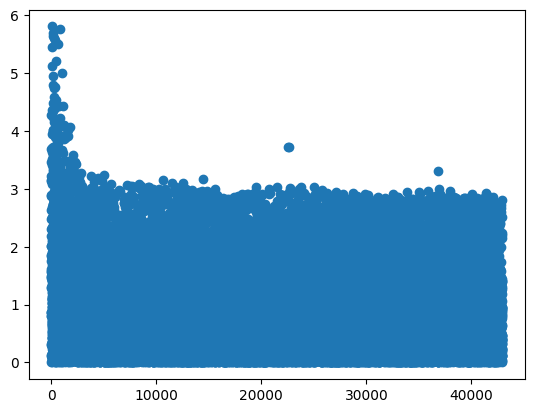

In [ ]:
oldModel = oldModel(Layers=[
    Dense_Layer(input_shape=9,output_shape=30, activation_func="lrelu"),
    Dense_Layer(input_shape=30,output_shape=6, activation_func="lrelu"),
    Output_Layer(input_shape=6,output_shape=1)
])

err = []

for x in range(3):
    err += oldModel.fit(train_X, train_y, 0.0001)
plt.scatter(range(len(err)), err, s=1)
plt.show()

old_train_err = np.convolve([x[0] for x in err], np.ones(1000)/1000, mode='valid')
plt.plot(old_train_err, label="Train Error", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()
plt.title("{layers}-Layer Deep Neural Network Error".format(layers=len(oldModel.get_Layers())))
plt.show()

Epoch 1/3, Average Loss: 1.0455093999061107
Epoch 2/3, Average Loss: 0.7570068923847054
Epoch 3/3, Average Loss: 0.5973411570407696


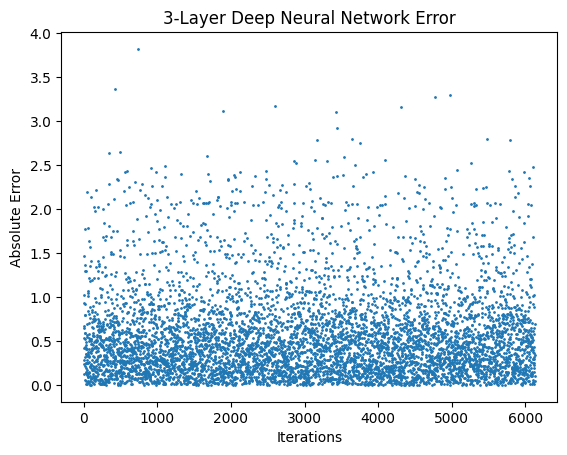

In [38]:
long_test_err = []
long_train_err = []

tf_err = []

train_X, train_y, test_X, test_y = shuffle_scale(housing_data, 0.3)
train_err = my_model.fit(train_X, train_y, epochs=3, learning_rate=0.0001)
tf_err.append(model.fit(train_X, train_y, epochs=3, batch_size=32, verbose=0))
test_err = []
for i in range(len(test_X)):
    pred = my_model.forward_pass(test_X[i])
    test_err.append(abs(pred - test_y[i]))
long_test_err += test_err
long_train_err += train_err

plt.scatter(range(len(long_test_err)), long_test_err, s=1)
plt.xlabel("Iterations")
plt.ylabel("Absolute Error")
plt.title(f"{len(my_model.get_Layers())}-Layer Deep Neural Network Error")
plt.show()

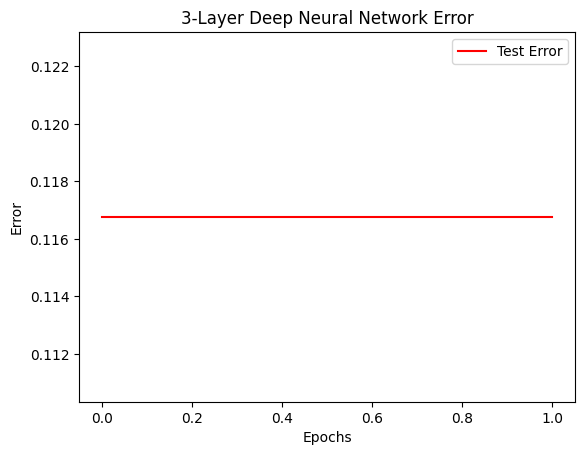

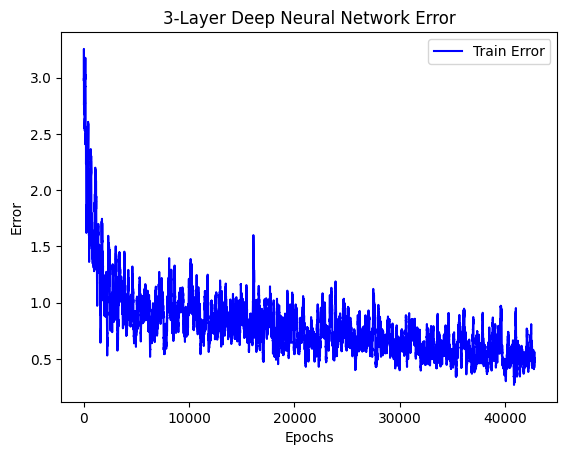

In [49]:
mv_train_err = np.convolve(long_train_err[0], np.ones(100)/100, mode='valid')

# Ensure long_test_err is a list of numerical values
mv_test_err = np.convolve(long_test_err[0], np.ones(2)/2, mode='valid')

plt.plot(mv_test_err, label="Test Error", color="red")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()
plt.title("{layers}-Layer Deep Neural Network Error".format(layers=len(my_model.get_Layers())))
plt.show()
plt.plot(mv_train_err, label="Train Error", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()
plt.title("{layers}-Layer Deep Neural Network Error".format(layers=len(my_model.get_Layers())))
plt.show()

(0.0, 500000.0)

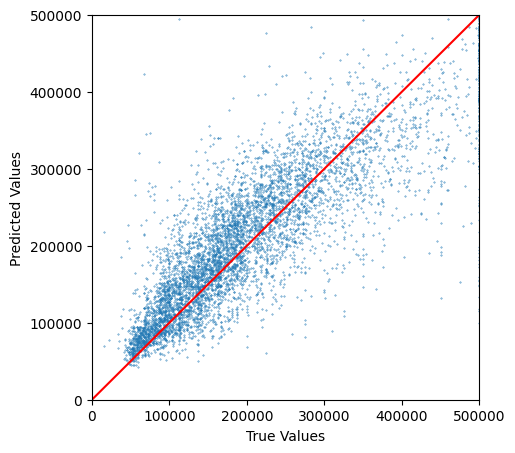

In [53]:
plt.figure(figsize=(7, 7))
plt.scatter(test_y[:6129], [my_model.forward_pass(test_X[d]) for d in range(6129)], s=0.11)
plt.plot([0, 500000], [0, 500000], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
# make the axes the same range
plt.xlim(0, 500000)
plt.ylim(0, 500000)

## MNIST Digit Recognizer DataSet

Moving onto the MNIST Digit Recongizer DataSet, we will be classifying handwritten numbers into their corresponding digits.

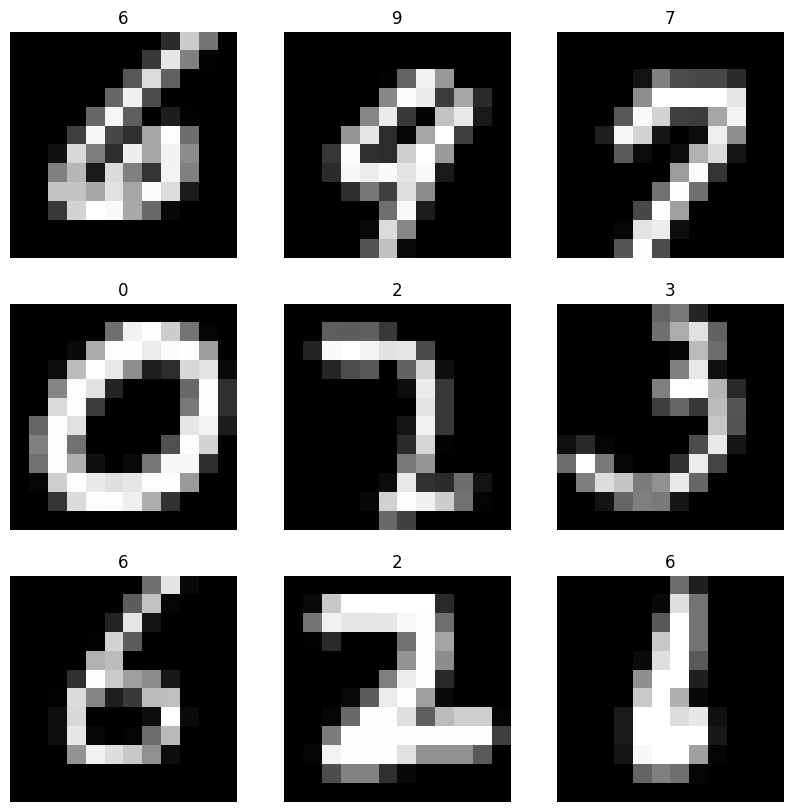

In [4]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = tf.image.resize(X_train[..., tf.newaxis], [14, 14]).numpy()
X_test = tf.image.resize(X_test[..., tf.newaxis], [14, 14]).numpy()

X_train = X_train[:, 1:-1, 1:-1]
X_test = X_test[:, 1:-1, 1:-1]

X_train = X_train.reshape((X_train.shape[0], 12 * 12)).astype('float32') / 255
X_test = X_test.reshape((X_test.shape[0], 12 * 12)).astype('float32') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# shuffle
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)
X_train = X_train[indices]
y_train = y_train[indices]

# visualize the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i].reshape(12, 12), cmap='gray')
    plt.title(np.argmax(y_train[i]))
    plt.axis('off')
plt.show()

In [5]:
from Model import *

model = Model(Layers=[
    Dense_Layer(input_shape=144, output_shape=32, activation_func="relu"),
    Dense_Layer(input_shape=32, output_shape=20, activation_func="relu"),
    Output_Layer(input_shape=20, output_shape=10, activation_func="softmax")
])

model.summary()

Dense Layer  | 32 neurons | 144 weights | 1 bias
Dense Layer  | 20 neurons | 32 weights | 1 bias
Output Layer | 10 outputs | 20 weights | 1 bias
Input Shape: 144
Output Shape: 10


Epoch 1/1, Average Loss: 0.013945001952272641


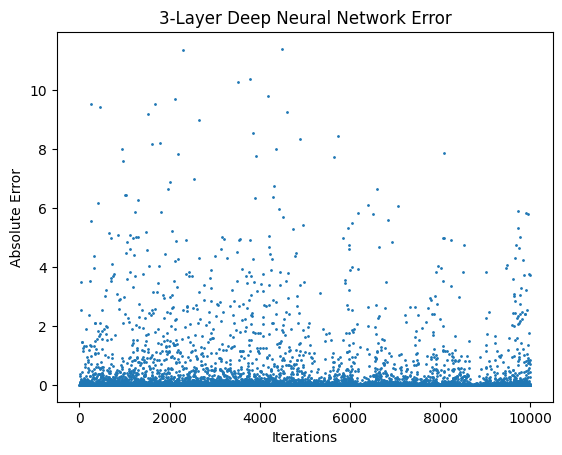

In [6]:
long_test_err = []
long_train_err = []

train_err, best_model = model.fit(X_train, y_train, epochs=1, learning_rate=0.01)
test_err = []
for i in range(len(X_test)):
    pred = best_model.forward_pass(X_test[i])
    # cross entropy loss
    test_err.append(-np.log(pred[np.argmax(y_test[i])]))
long_test_err += test_err
long_train_err += train_err

plt.scatter(range(len(long_test_err)), long_test_err, s=1)
plt.xlabel("Iterations")
plt.ylabel("Absolute Error")
plt.title(f"{len(model.get_Layers())}-Layer Deep Neural Network Error")
plt.show()

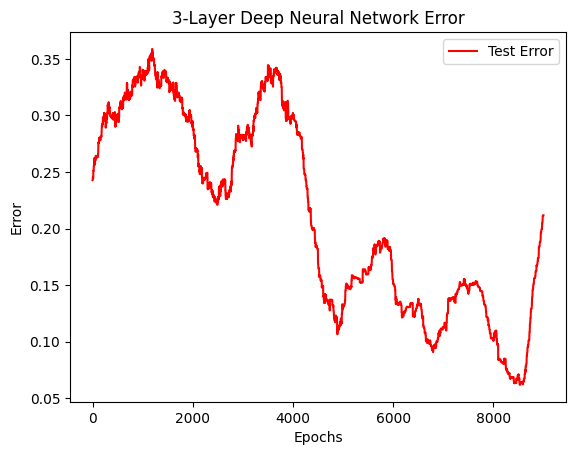

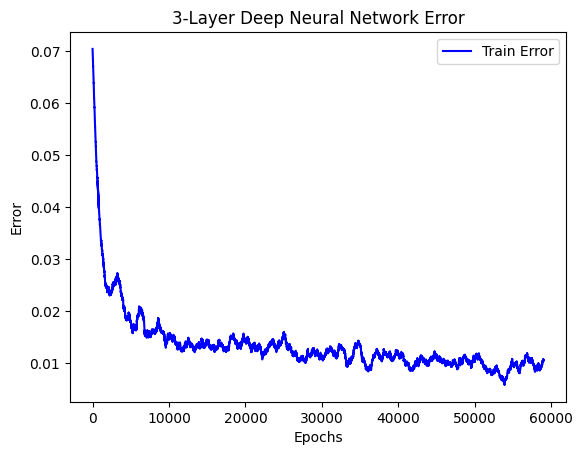

In [7]:
mv_train_err = np.convolve(long_train_err, np.ones(1000)/1000, mode='valid')

mv_test_err = np.convolve(long_test_err, np.ones(1000)/1000, mode='valid')

plt.plot(mv_test_err, label="Test Error", color="red")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()
plt.title("{layers}-Layer Deep Neural Network Error".format(layers=len(model.get_Layers())))
plt.show()
plt.plot(mv_train_err, label="Train Error", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()
plt.title("{layers}-Layer Deep Neural Network Error".format(layers=len(model.get_Layers())))
plt.show()

Accuracy: 0.9398
Recall: 0.9894273127753304
Best Accuracy: 0.9354
Best Recall: 0.9894273127753304


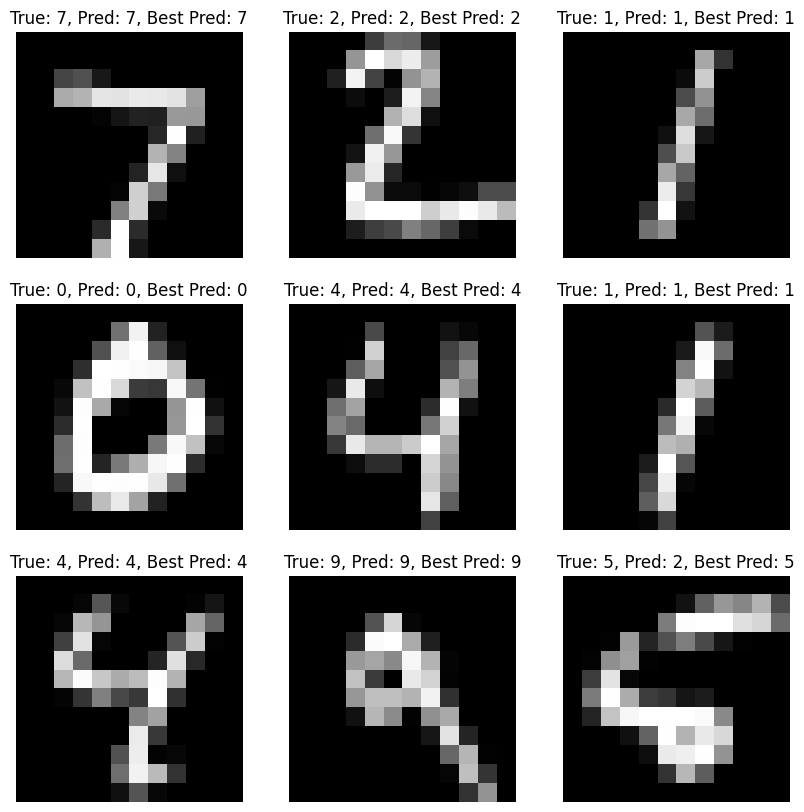

In [8]:
predictions = [model.forward_pass(X_test[i]) for i in range(len(X_test))]
best_predictions = [best_model.forward_pass(X_test[i]) for i in range(len(X_test))]

accuracy = np.mean([np.argmax(predictions[i]) == np.argmax(y_test[i]) for i in range(len(predictions))])
print(f"Accuracy: {accuracy}")
true_positives = np.sum([np.argmax(predictions[i]) == 1 and np.argmax(y_test[i]) == 1 for i in range(len(predictions))])
false_negatives = np.sum([np.argmax(predictions[i]) != 1 and np.argmax(y_test[i]) == 1 for i in range(len(predictions))])
recall = true_positives / (true_positives + false_negatives)
print(f"Recall: {recall}")

best_accuracy = np.mean([np.argmax(best_predictions[i]) == np.argmax(y_test[i]) for i in range(len(best_predictions))])
print(f"Best Accuracy: {best_accuracy}")
best_true_positives = np.sum([np.argmax(best_predictions[i]) == 1 and np.argmax(y_test[i]) == 1 for i in range(len(best_predictions))])
best_false_negatives = np.sum([np.argmax(best_predictions[i]) != 1 and np.argmax(y_test[i]) == 1 for i in range(len(best_predictions))])
best_recall = true_positives / (true_positives + false_negatives)
print(f"Best Recall: {best_recall}")

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[i].reshape(12, 12), cmap='gray')
    plt.title(f"True: {np.argmax(y_test[i])}, Pred: {np.argmax(predictions[i])}, Best Pred: {np.argmax(best_predictions[i])}")
    plt.axis('off')
plt.show()

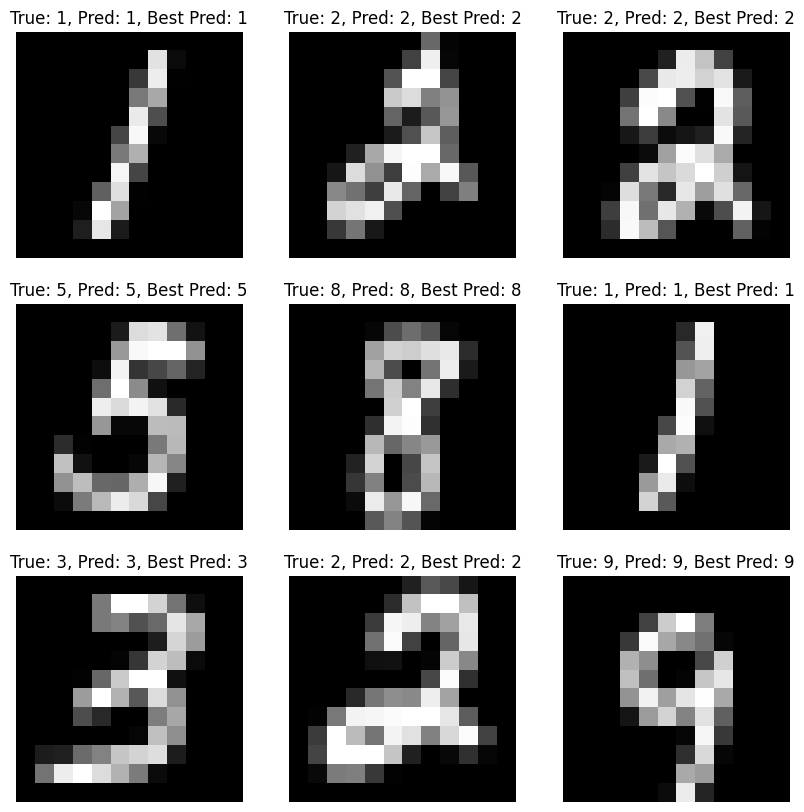

: 

In [12]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[7000+i].reshape(12, 12), cmap='gray')
    plt.title(f"True: {np.argmax(y_test[7000+i])}, Pred: {np.argmax(predictions[7000+i])}, Best Pred: {np.argmax(best_predictions[7000+i])}")
    plt.axis('off')
plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from Model import *

class ModelVisualizer(Model):
    def visualize_forward_pass(self, X):
        activations = [X]
        input = X
        for layer_index, layer in enumerate(self.get_Layers()):
            output = layer.forward_pass(input)
            activations.append(output)
            input = output
        
        # Plot activations layer by layer
        fig, axs = plt.subplots(len(activations), figsize=(8, len(activations) * 3))
        for idx, activation in enumerate(activations):
            axs[idx].imshow(np.atleast_2d(activation).T, cmap='viridis', aspect='auto')
            axs[idx].set_title(f"Layer {idx} Activations")
        
        plt.tight_layout()
        plt.show()